## Phase 1 - Project Setup ##

In [2]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [3]:
df = pd.read_csv("1_Recipe_csv.csv") # Loads csv file
df.head() # Displays first few rows in csv

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a b...","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablesp...","[""Combine ketchup, beer, Worcestershire sauce,...",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,These gochujang pork belly bites are sweet and...,"[""1 pound pork belly"", ""1/4 cup gochujang"", ""2...","[""Preheat an air fryer to 400 degrees F (200 d...",5,4
2,3-Ingredient Air Fryer Everything Bagel Chicke...,Air Fryer Recipes,Air Fryer Recipes,These 3-ingredient air fryer everything bagel ...,"[""1 \u00bc pounds chicken tenders"", ""1 tablesp...","[""Gather all ingredients. Preheat an air fryer...",3,4
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,These air fryer everything bagel chicken cutle...,"[""4 chicken cutlets (about 1 pound total)"", ""s...","[""Preheat an air fryer to 400 degrees F (200 d...",9,9
4,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,Air Fryer Recipes,These air fryer honey Sriracha salmon bites ar...,"[""1 tablespoon soy sauce"", ""1 tablespoon honey...","[""Preheat an air fryer to 400 degrees F (200 d...",5,5


In [4]:
df.describe() # Generates descriptive statistics

,num_ingredients,num_steps
count,62126.000000,62126.000000
mean,9.017448,4.661865
std,3.830323,2.310253
min,1.000000,1.000000
25%,6.000000,3.000000
50%,9.000000,4.000000
75%,11.000000,6.000000
max,35.000000,25.000000


In [5]:
df.isnull() # Checks for missing values

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
62121,False,False,False,False,False,False,False,False
62122,False,False,False,False,False,False,False,False
62123,False,False,False,False,False,False,False,False
62124,False,False,False,False,False,False,False,False


In [6]:
df.columns 

Index(['recipe_title', 'category', 'subcategory', 'description', 'ingredients',
       'directions', 'num_ingredients', 'num_steps'],
      dtype='object')

In [7]:
df.dtypes

recipe_title       object
category           object
subcategory        object
description        object
ingredients        object
directions         object
num_ingredients     int64
num_steps           int64
dtype: object

In [8]:
df.isnull().sum()

recipe_title       0
category           0
subcategory        0
description        0
ingredients        0
directions         0
num_ingredients    0
num_steps          0
dtype: int64

## Phase 2 - Data Cleaning & Preprocessing ##

**Parse Ingredients**

In [11]:
# Parse ingredients
def parse_ingredients(x):
    
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            # treat the whole string as one ingredient
            return [x]
            # if it's something weird return empty list
            return []

df["ingredients_list"] = df["ingredients"].apply(parse_ingredients)

df["ingredients_list"].head()

0    [3/4 cup ketchup, 1/2 cup beer, 1 tablespoon W...
1    [1 pound pork belly, 1/4 cup gochujang, 2 tabl...
2    [1 ¼ pounds chicken tenders, 1 tablespoon oliv...
3    [4 chicken cutlets (about 1 pound total), salt...
4    [1 tablespoon soy sauce, 1 tablespoon honey, 1...
Name: ingredients_list, dtype: object

**Clean & Normalize Ingredients**

In [13]:
MEASUREMENT_WORDS = {
    "cup","cups","tablespoon","tablespoons","tbsp","tbsps",
    "teaspoon","teaspoons","tsp","tsps",
    "pound","pounds","lb","lbs",
    "ounce","ounces","oz",
    "gram","grams","g","kg",
    "ml","liter","liters","l",
    "slice","slices","clove","cloves","pinch","dash",
    "package","packages","can","cans"
}

# Remove descriptive cooking adjectives
COOKING_ADJECTIVES = {
    "diced","chopped","minced","fresh","green","red","yellow","small","large","medium",
    "boneless","skinless","thin","thick","whole"
}
 
# Words that should not appear alone
LOW_VALUE_WORDS = {
    "white","all","purpose","extract","powder","oil"
}

def clean_single_ingredient(ing):
    if not isinstance(ing, str):
        return ""

    ing = ing.lower()

    # Replace "and" with comma to split multi-ingredients
    ing = ing.replace(" and ", ", ")

    # Remove numbers, fractions, parentheses, punctuation
    ing = re.sub(r"\d+/\d+", " ", ing)
    ing = re.sub(r"\d+", " ", ing)
    ing = re.sub(r"\(.*?\)", " ", ing)
    ing = re.sub(r"[^a-z\s,]", " ", ing)

    # Split multi-ingredient lines into phrases
    parts = [p.strip() for p in ing.split(",")]

    cleaned_phrases = []

    for phrase in parts:
        tokens = phrase.split()

        # Remove measurement words & cooking adjectives
        tokens = [
            t for t in tokens
            if t not in MEASUREMENT_WORDS
            and t not in COOKING_ADJECTIVES
        ]

        if len(tokens) == 1 and tokens[0] in LOW_VALUE_WORDS:
            continue

        cleaned = " ".join(tokens).strip()

        if cleaned:
            cleaned_phrases.append(cleaned)

    return cleaned_phrases

def clean_ingredients_list(lst):
    normalized = []
    for ing in lst:
        for cleaned in clean_single_ingredient(ing):
            normalized.append(cleaned)

    normalized = list(set(normalized))

    return normalized

df["final_ingredients"] = df["ingredients_list"].apply(clean_ingredients_list)

df["final_ingredients"].head(10)


0    [beer, freshly ground black pepper, ketchup, b...
1    [gochujang, pork belly, ground ginger, soy sau...
2    [olive oil, everything bagel seasoning or to t...
3    [milk, chicken cutlets, parchment, salt, fresh...
4    [rice vinegar, soy sauce, honey, sriracha, gra...
5    [or to taste, mayonnaise, chili powder, lime j...
6    [lime, thai sweet chili sauce, salt to taste, ...
7    [or to taste, cooking spray, salt, onion, caye...
8    [hot honey, nonstick cooking spray, butter, su...
9    [olive oil, onion, salt, freshly ground black ...
Name: final_ingredients, dtype: object

**Define flavor keyword dictionaries**

In [15]:
FLAVOR_PROFILES = {
    "sweet": [
        "sugar", "honey", "maple", "syrup", "brown sugar",
        "molasses", "sweet"
    ],
    "spicy": [
        "sriracha", "chili", "pepper flakes", "cayenne", "jalapeno",
        "gochujang", "hot sauce"
    ],
    "savory": [
        "soy sauce", "garlic", "onion", "ginger", "mushroom", "umami",
        "worcestershire"
    ],
    "creamy": [
        "cream", "milk", "cheese", "mayo", "butter", "cream cheese",
        "yogurt"
    ],
    "herby": [
        "cilantro", "parsley", "basil", "oregano", "thyme", "dill",
        "green onion", "scallion"
    ],
    "carb": [
        "flour", "breadcrumbs", "panko", "potato", "rice", "corn",
        "tortilla", "pasta"
    ],
}

PROTEINS = {
    "chicken": ["chicken", "tenders", "cutlets", "thighs"],
    "pork": ["pork", "pork belly"],
    "beef": ["beef"],
    "fish": ["salmon", "tilapia", "cod"],
    "vegetarian": ["tofu", "mushroom", "eggplant"],
}


**Flavour Feature**

Convert every recipe into an 8 dimensional vector

In [82]:
def extract_flavor_features(ingredients):
    text = " ".join([i.lower() for i in ingredients])

    features = []

    # Flavor profile binary features
    for flavor, keywords in FLAVOR_PROFILES.items():
        features.append(
            1 if any(k in text for k in keywords) else 0
        )

    # Protein type
    protein_vector = [0, 0, 0, 0, 0]  # chicken, pork, beef, fish, vegetarian
    protein_keys = list(PROTEINS.keys())

    assigned = False
    for idx, p in enumerate(protein_keys):
        if any(k in text for k in PROTEINS[p]):
            protein_vector[idx] = 1
            assigned = True
            break

    if not assigned:
        protein_vector[-1] = 1

    return features + protein_vector


**Apply to dataset**

In [19]:
feature_matrix = df["ingredients_list"].apply(extract_flavor_features)
X = np.vstack(feature_matrix.values)

print("Feature matrix shape:", X.shape)


Feature matrix shape: (62126, 11)


## Phase 5 - Clustering ##

**Find best k value**

In [22]:
K_values = [2, 3, 4, 5, 6, 7, 8]

inertias = []
silhouettes = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)

    inertia = kmeans.inertia_
    inertias.append(inertia)

    # silhouette only works when k > 1
    sil = silhouette_score(X, labels)
    silhouettes.append(sil)

    print(f"K = {k} → Inertia = {inertia:.2f}, Silhouette = {sil:.4f}")


K = 2 → Inertia = 80639.17, Silhouette = 0.2738
K = 3 → Inertia = 70012.65, Silhouette = 0.2691
K = 4 → Inertia = 64864.25, Silhouette = 0.2540
K = 5 → Inertia = 57695.41, Silhouette = 0.2798
K = 6 → Inertia = 54452.55, Silhouette = 0.2842
K = 7 → Inertia = 52019.83, Silhouette = 0.2935
K = 8 → Inertia = 47285.19, Silhouette = 0.3418


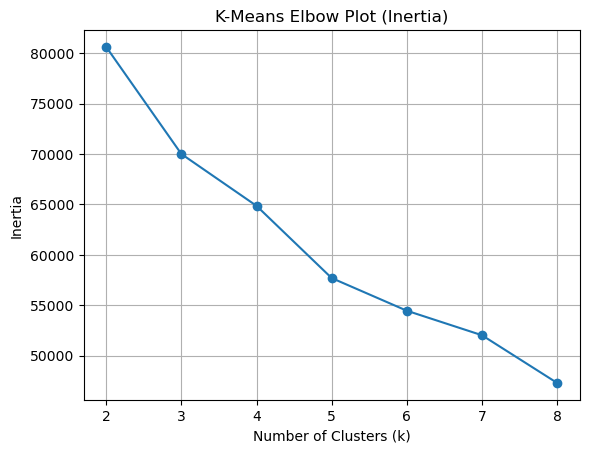

In [23]:
import matplotlib.pyplot as plt

plt.plot(K_values, inertias, marker='o')
plt.title("K-Means Elbow Plot (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


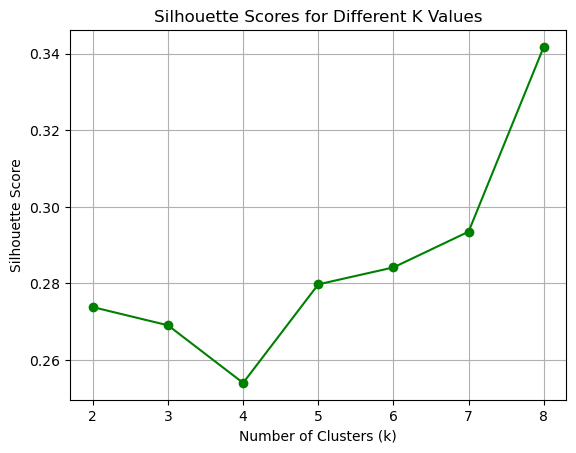

In [24]:
plt.plot(K_values, silhouettes, marker='o', color='green')
plt.title("Silhouette Scores for Different K Values")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


**Run K-Means on flavour features**

In [68]:
BEST_K = 8

kmeans = KMeans(n_clusters=BEST_K, random_state=0)
clusters = kmeans.fit_predict(X)
labels = kmeans.fit_predict(X)

df["flavor_cluster"] = clusters
df["flavor_cluster"].value_counts()
df["cluster_label"] = labels


**Interpret cluster flavours**

Determines:
* Which cluster is most sweet
* Which cluster is spicy
* Which cluster is herby
* Which cluster is carb heavy
* and the dominant protein

In [28]:
centers = kmeans.cluster_centers_

cluster_profiles = pd.DataFrame(
    centers,
    columns=[
        "sweet","spicy","savory","creamy","herby","carb",
        "protein_chicken","protein_pork","protein_beef","protein_fish","protein_veg"
    ]
)

cluster_profiles


,sweet,spicy,savory,creamy,herby,carb,protein_chicken,protein_pork,protein_beef,protein_fish,protein_veg
0,2.338347e-01,0.264309,8.866966e-01,5.321352e-01,0.380934,4.350459e-01,1.151856e-15,1.873501e-16,1.000000e+00,1.214306e-17,2.331468e-15
1,-9.603429e-15,0.069832,-5.551115e-17,5.807759e-01,0.103880,3.613202e-01,1.304512e-15,3.705848e-02,5.967449e-16,1.505501e-02,9.478865e-01
2,6.714386e-01,0.144098,6.646327e-01,4.218847e-15,0.235508,1.111241e-01,1.318390e-15,2.898381e-02,5.828671e-16,1.138230e-02,9.596339e-01
3,1.000000e+00,0.024780,1.009129e-01,1.000000e+00,0.013857,-7.216450e-15,4.727747e-03,4.727747e-03,1.956309e-03,3.423541e-03,9.851647e-01
4,2.181977e-01,0.668340,9.391228e-01,4.025747e-01,0.708924,4.481780e-01,1.082467e-15,4.093389e-01,3.330669e-16,8.422431e-02,5.064368e-01
5,5.828221e-02,0.074177,1.000000e+00,8.463469e-01,0.467373,5.210541e-01,1.262879e-15,3.885781e-16,5.273559e-16,6.413832e-03,9.935862e-01
6,1.000000e+00,0.010431,6.410611e-02,8.088560e-01,0.007392,1.000000e+00,9.671180e-04,7.598784e-04,8.980381e-04,4.144791e-04,9.969605e-01
7,1.732799e-01,0.283233,8.329993e-01,5.742151e-01,0.463861,5.576486e-01,1.000000e+00,9.020562e-17,5.551115e-16,1.734723e-18,6.883383e-15


**Rounded, easier to vizualize values**

In [30]:
cluster_profiles = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=[
        "sweet","spicy","savory","creamy","herby","carb",
        "protein_chicken","protein_pork","protein_beef","protein_fish","protein_veg"
    ]
)

cluster_profiles.round(2)


,sweet,spicy,savory,creamy,herby,carb,protein_chicken,protein_pork,protein_beef,protein_fish,protein_veg
0,0.23,0.26,0.89,0.53,0.38,0.44,0.0,0.00,1.0,0.00,0.00
1,-0.00,0.07,-0.00,0.58,0.10,0.36,0.0,0.04,0.0,0.02,0.95
2,0.67,0.14,0.66,0.00,0.24,0.11,0.0,0.03,0.0,0.01,0.96
3,1.00,0.02,0.10,1.00,0.01,-0.00,0.0,0.00,0.0,0.00,0.99
4,0.22,0.67,0.94,0.40,0.71,0.45,0.0,0.41,0.0,0.08,0.51
5,0.06,0.07,1.00,0.85,0.47,0.52,0.0,0.00,0.0,0.01,0.99
6,1.00,0.01,0.06,0.81,0.01,1.00,0.0,0.00,0.0,0.00,1.00
7,0.17,0.28,0.83,0.57,0.46,0.56,1.0,0.00,0.0,0.00,0.00


**Cluster 0 - Savory Beef Based Dishes with Creamy/Herby Notes**
* Examples: Beef bowls, ground beef air-fryer dishes, garlic butter beef dishes.

**Cluster 1 - Mild, Creamy Vegetarian Dishes**
* Examples: Creamy corn, creamed vegetables, mayo sauces.

**Cluster 2 - Sweet & Mild Vegetarian Dishes**
* Examples: Honey carrots, glazed potatoes, sweet veggie dishes.

**Cluster 3 - Dessert Like Sweet + Creamy Vegetarian Foods**
* Examples: Cream + sugar mixtures, dessert dips, sweet cream cheese mixes.

**Cluster 4 - Spicy-Savory Pork or Mixed Meat**
* Examples: Gochujang pork belly, spicy air fryer bites, chili-based pork seasoning.

**Cluster 5 - Savory, Herby, Low Cream Vegetarian Side Dishes**
* Examples: Herb roasted potatoes, crispy onions, herby air fryer veggie dishes.

**Cluster 6 - Sweet + Savory Chicken With Carbs**
* Examples: Honey chicken, sweet glazes on chicken, breaded sweet-spicy chicken strips.

**Cluster 7 - Savory Creamy Carb Chicken**
* Examples: Creamy chicken cutlets, garlic butter chicken, chicken with creamy glaze.

## Testing ##

In [88]:
def test_seed_recipe(seed_ingredients):
    # Convert seed ingredients to flavor features
    seed_features = np.array(extract_flavor_features(seed_ingredients)).reshape(1, -1)
    
    # Predict cluster
    seed_cluster = kmeans.predict(seed_features)[0]
    
    print("Seed ingredients:")
    print(seed_ingredients)
    print("\nAssigned cluster:", seed_cluster)
    
    # Show that cluster's flavor profile
    print("\nCluster flavor center:")
    print(cluster_profiles.round(2).iloc[seed_cluster])
    
    # Show some real recipes from this cluster
    print("\nExample recipes in this cluster:")
    display(df[df["cluster_label"] == seed_cluster][["recipe_title", "ingredients"]].head(5))

test_seed_recipe([
    "chicken thighs", "honey", "soy sauce", "sriracha",
    "garlic", "ginger", "flour", "panko"
])


Seed ingredients:
['chicken thighs', 'honey', 'soy sauce', 'sriracha', 'garlic', 'ginger', 'flour', 'panko']

Assigned cluster: 7

Cluster flavor center:
sweet              0.17
spicy              0.28
savory             0.83
creamy             0.57
herby              0.46
carb               0.56
protein_chicken    1.00
protein_pork       0.00
protein_beef       0.00
protein_fish       0.00
protein_veg        0.00
Name: 7, dtype: float64

Example recipes in this cluster:


,recipe_title,ingredients
2,3-Ingredient Air Fryer Everything Bagel Chicke...,"[""1 \u00bc pounds chicken tenders"", ""1 tablesp..."
3,Air Fryer Everything Bagel Chicken Cutlets,"[""4 chicken cutlets (about 1 pound total)"", ""s..."
6,Air Fryer Peanut Chicken,"[""2 tablespoons Thai sweet chili sauce"", ""1 ta..."
14,Air Fryer Pesto Chicken Quinoa Bowl,"[""2 teaspoons pesto"", ""1/4 teaspoon garlic pow..."
18,Wet Wet Wings,"[""2 pounds chicken wings and drummettes"", ""1 t..."
